In [1]:
import sys
import torch
import algos
import numpy as np
import math
import numpy.random as random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

Closed form solution: beta = np.linalg.inv(X.T @ X) @ X.T @ y

Consider the scenario where:
- $x$ ~ $N(0, I_{dxd})$
- $y|x$ ~ $N(\langle x,\beta \rangle, \sigma^2)$
- We NOW DO NOT know $\frac{1}{n}X^TX = I_{dxd}$
- Need to estimate $ \frac{1}{n}X^Ty \approx E(x * \langle x, \beta \rangle) $
- Use CoinPress with input $z_i = x_iy_i$
- AND need to estimate $ (\frac{1}{n}X^TX)^{-1} \approx (\frac{1}{n}Cov(X))^{-1} $
- Use CoinPress with input $x_i$


But another thing we need to consider is that CoinPress assumes covariance matrix of z is $I_{dxd}$
- Can we assume this? No...
- Therefore we must normalize the $z_i$'s that we pass to CoinPress
- We have calculated the diagonals of $cov(Z)$ are $\beta_j^2  + ||\beta||_2^2 + 1$ 
- Since as of right now, $\beta$ ~ $N(0,1)$, $\beta_j^2 = 1$, $||\beta||_2^2 = d$, so each diagonal entry is approx $d+2$
- Therefore, if the diagonals are >> the non-diagonals, we can assume that $\frac{z}{\sqrt{d}}$ ~ $N(C, I_{dxd})$


In [2]:
def generate_data(n,d):
    
    """Creates an nxd matrix X, a 1xd underlying_dist vector, nx1 y vector, and nxd z vector (where zi=xi*yi)"""
    
    # generate an n x d data matrix with N(0,1) entries- feature matrix
    X = random.normal(0,1.0,(n,d))
    X = np.array(X)
    
    # underlying distribution (beta hat)
    underlying_dist = random.normal(0,1.0,(1,d))
    underlying_dist = np.array(underlying_dist)
    
    # Generates a label vector from underlying distribution plus some noise
    y = []
    for i in range(n):
        y.append(np.dot(underlying_dist, X[i])[0] + random.normal(0,1))
    y = np.array(y)  
    
    # Generate z = xy
    z = []
    for i in range(n):
        z.append(X[i] * y[i])
    z = np.array(z)
    
    return X,y,z,underlying_dist

In [3]:
def covariance_matrix(z):
    z = z - underlying_dist
    return (z.T@z)/n  # z.t@z grows w n

In [4]:
def predicted_covariance():
    predicted_cov = np.zeros((d,d))
    for row in range(d):
        for col in range(d):
            if row == col:
                predicted_cov[row][col] = underlying_dist[0][row]**2 + np.linalg.norm(underlying_dist[0]) ** 2 + 1 
            else:
                predicted_cov[row][col] = underlying_dist[0][row]*underlying_dist[0][col]
                
    return predicted_cov

In [5]:
def coinpress_linreg_mean(z, c, r, d, beta_norm_sqr=None, t=2, total_budget=0.5):
    if beta_norm_sqr is None: 
        beta_norm_sqr = d
    z = z/np.sqrt(2*beta_norm_sqr+1)
    rho = [(1.0/4.0)*total_budget, (3.0/4.0)*total_budget]
    return algos.multivariate_mean_iterative(z, c, r, t, rho)*np.sqrt(2*beta_norm_sqr+1)

In [6]:
def coinpress_linalg_covariance(x, d, t=2, total_budget=0.5):
    '''need X and args={d, u, rho, t}'''
    x = torch.FloatTensor(x)
    class Args:
        def __init__(self, n, d, u, rho, t):
            self.n = n
            self.d = d
            self.u = u
            self.rho = rho
            self.t = t
    n = len(x)
    rho = [(1.0/4.0)*total_budget, (3.0/4.0)*total_budget]
    u = 10 * np.sqrt(d)
    args = Args(n, d, u, rho, t)
    return algos.cov_est(x, args)

In [7]:
x = random.normal(0,1.0,(2000,50))
x = torch.FloatTensor(x)
np.array(coinpress_linalg_covariance(x, 50))

array([[22.403831  ,  1.3659672 ,  2.0771546 , ..., -1.1708544 ,
        -0.5282894 ,  1.9744301 ],
       [ 1.365955  , 15.840675  , -1.3151397 , ...,  1.5317687 ,
        -0.77592933,  3.6487315 ],
       [ 2.0771556 , -1.3151358 , 23.579144  , ..., -2.1468685 ,
         2.1946502 , -1.3288009 ],
       ...,
       [-1.1708528 ,  1.5317731 , -2.1468625 , ..., 26.349161  ,
         0.5487872 , -1.9835037 ],
       [-0.5282922 , -0.77592653,  2.1946492 , ...,  0.54877245,
        25.765282  , -1.9798689 ],
       [ 1.9744351 ,  3.648742  , -1.3287938 , ..., -1.9835054 ,
        -1.9798774 , 21.833055  ]], dtype=float32)

In [8]:
def error(z,c,r,d,iters):
    errors = []
    for i in range(iters):
        error = np.linalg.norm(np.mean(z, axis=0) - coinpress_linreg_mean(z, c, r, d))
        errors.append(error)
        
    return errors

To analyze how well this algorithm works, we can find it's excess loss:
$$\mathbb{E}[(\langle x, \hat{\beta} \rangle - y)^2 - (\langle x, \beta \rangle - y)^2]$$
Because what we really care about is how well our estimate for $\hat{\beta}$ predicts the true values.

In [9]:
def excess_loss(beta_hat, beta, d):
    """ generate n d-dimensional x values and y values to test excess loss of our predicted beta_hat vs. underlying distribution beta """
    
    n = 1000
    x = random.normal(0,1.0,(n,d))
    x = np.array(x)
    y = []
    
    for i in range(n):
        y.append(np.dot(beta, x[i]) + random.normal(0,1))
    y = np.array(y)  
    
    sum_losses = 0
    n = len(x)
    for i in range(n):
        predicted_dist = (x[i] @ beta_hat - y[i])**2
        actual_dist = (x[i] @ beta - y[i])**2 # if this = 1, it's essentially the same thing as n -> \inf
        loss = predicted_dist - actual_dist
        sum_losses += loss
    return sum_losses / n

In [10]:
def nonprivate_linreg_mean(x, y):
    """ find beta_hat from distribution """
    
    # Create linear regression object
    regr = linear_model.LinearRegression()

    n = len(y)
    # Train the model using the training sets
#     regr.fit(x, y)
#     return (x.T @ y) / n
    return np.linalg.inv(x.T @ x) @ x.T @ y
#     return regr.coef_

Compare to: what if we did not add privacy - default solution to lin reg.
- given data, what is solution, compare excess loss (use scipy linreg / closed form)
- get a sense of what is a 'normal' excess risk
- still wouldn't be zero, would help to have a sense of checking our baseline
- As n goes to infinity, should have excess risk going to 0.
- saw comparing it to CoinPress high total_budget doesn't make too significant a diff

If we evaluate on new data, optimal soln is underlying_dist, expected loss of optimal soln 1
- better to evaluate on a new dataset (generate x same way, y using underlying_dist) !!!
- in expectation, actual loss is 1


Messing around with other underlying distributions ($\beta$)
- Nothing about our assumptions relies on $\beta$ ~ $N(0,1)$
- Will first try out running experiment with $N(\mu, \sigma^2)$, varying $\mu$ and $\sigma$
- Then, we will need to rescale each $z_i$ by $2 \|\beta\|^{2}_2 + 1$
- Moving forward, will need to estimate $\|\beta\|^{2}_2$

In [11]:
def generate_data_beta_normal(n,d,beta_mean,beta_var):
    
    """Creates an nxd matrix X, a 1xd underlying_dist vector, nx1 y vector, and nxd z vector (where zi=xi*yi)"""
    
    # generate an n x d data matrix with N(0,1) entries- feature matrix
    X = random.normal(0,1.0,(n,d))
    X = np.array(X)
    
    # underlying distribution (beta hat)
    underlying_dist = random.normal(beta_mean,beta_var,(1,d))
    underlying_dist = np.array(underlying_dist)
    
    # Generates a label vector from underlying distribution plus some noise
    y = []
    for i in range(n):
        y.append(np.dot(underlying_dist, X[i])[0] + random.normal(0,1))
    y = np.array(y)  
    
    # Generate z = xy
    z = []
    for i in range(n):
        z.append(X[i] * y[i])
    z = np.array(z)
    
    return X,y,z,underlying_dist

In [12]:
def run_experiment_beta_normal(d, beta_mean=0, beta_var=1, iters=30):
    n_values = [2000, 4000, 6000, 8000, 10000]
#     n_values = [4000, 6000, 8000, 10000]
#     n_values = [100, 500, 1000, 5000]
    c = [0]*d
#     r = 10*np.sqrt(d)
    r = 100*np.sqrt(d)
    
    # want to keep track and plot coinpress vs. non-private excess loss
    losses = []
    nonpriv_losses = []

    for n in n_values:
        """ for all n values, take the average of the loss after running the trial t times"""
        curr_losses = []
        curr_nonpriv_losses = []
        for i in range(iters):
            # generated data = nxd matrix x, nx1 vector y, nxd matrix z
            # TODO: eventually change how to find beta_norm
            x,y,z,underlying_dist = generate_data_beta_normal(n,d,beta_mean,beta_var)
            beta_norm = np.linalg.norm(underlying_dist) ** 2
            
            # generate b_hat, and it's nonprivate counterpart by using coinpress and general linreg respectively
            b_hat = coinpress_linreg_mean(z, c, r, d, beta_norm, total_budget=0.5)@np.linalg.inv(np.array(coinpress_linalg_covariance(x, d)))
            nonpriv_b_hat = nonprivate_linreg_mean(x,y)

            # find excess loss of b_hat and nonprivate b_hat
            loss = excess_loss(b_hat, underlying_dist[0], d)
            nonpriv_loss = excess_loss(nonpriv_b_hat, underlying_dist[0], d)
            curr_nonpriv_losses.append(nonpriv_loss)
            curr_losses.append(loss)
        losses.append(np.mean(np.array(curr_losses)))
        nonpriv_losses.append(np.mean(np.array(curr_nonpriv_losses)))

    print(f"losses: {losses}")
    print(f"non-private losses: {nonpriv_losses}")
    plt.plot(n_values, losses, 'bo-')
    plt.plot(n_values, nonpriv_losses, 'rx--')

losses: [0.03569198403180949, 0.00757813611005436, 0.004431184041310101, 0.0036087832754494427, 0.0029591119926617162]
non-private losses: [0.0023515588971704045, 0.0012677412170793649, -0.00024490124995623405, 0.0011394386845674542, 0.00046195036966810204]


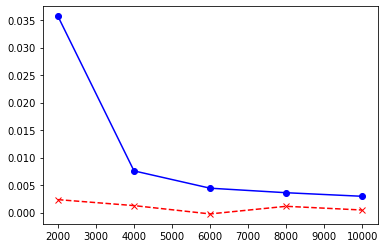

In [20]:
run_experiment_beta_normal(5)

In [14]:
# generate data
# then compare coinpress cov est to actual cov
x,y,z,underlying_dist = generate_data_beta_normal(2000,5,0,1)
print((1/2000)*x.T@x)
print(coinpress_linalg_covariance(x,5))

[[ 1.02289041e+00  2.40722155e-02  7.07324762e-03  1.02482289e-02
   1.26108368e-02]
 [ 2.40722155e-02  1.02762628e+00  1.82737773e-02  6.52412206e-04
  -3.32618144e-02]
 [ 7.07324762e-03  1.82737773e-02  1.04587825e+00  4.70536647e-02
   2.73775465e-02]
 [ 1.02482289e-02  6.52412206e-04  4.70536647e-02  1.00593284e+00
  -1.25188724e-02]
 [ 1.26108368e-02 -3.32618144e-02  2.73775465e-02 -1.25188724e-02
   1.01027231e+00]]
tensor([[ 9.9062e-01,  3.7000e-02,  1.2926e-04, -5.4188e-02,  2.8390e-02],
        [ 3.6999e-02,  1.0243e+00, -9.6644e-03,  5.6649e-03, -1.4044e-02],
        [ 1.2901e-04, -9.6640e-03,  1.0231e+00,  8.4457e-02, -3.2292e-02],
        [-5.4188e-02,  5.6648e-03,  8.4457e-02,  1.0537e+00, -6.1951e-02],
        [ 2.8390e-02, -1.4043e-02, -3.2292e-02, -6.1951e-02,  9.9548e-01]])


In [15]:
x = [True, False, True]
x = np.array(x)
print(np.mean(x))

0.6666666666666666
